In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error
import networkx as nx
import requests
import random

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
 
    return conn

def execute_query(connection, query):
    cur = connection.cursor()
    cur.execute(query)
    return cur.fetchall()

def julian_unix(julian):
    return 86400 * (julian - 2440587.5)

def probability_graph_fire_size(df):
    DG = nx.DiGraph()
    not_a = df[df['FIRE_SIZE_CLASS'] != 'A']
    not_b = not_a[not_a['FIRE_SIZE_CLASS'] != 'B']
    not_c = not_b[not_b['FIRE_SIZE_CLASS'] != 'C']
    not_d = not_c[not_c['FIRE_SIZE_CLASS'] != 'D']
    not_e = not_d[not_d['FIRE_SIZE_CLASS'] != 'E']
    not_f = not_e[not_e['FIRE_SIZE_CLASS'] != 'F']
    DG.add_weighted_edges_from([('A', 'B', round((not_a.shape[0] / df.shape[0]),2)), ('B', 'C', round((not_b.shape[0] / not_a.shape[0]), 2)), ('C', 'D', round((not_c.shape[0] / not_b.shape[0]),2)), ('D', 'E', round((not_d.shape[0] / not_c.shape[0]),2)), ('E', 'F', round((not_e.shape[0] / not_d.shape[0]),2)), ('F', 'G', round((not_f.shape[0] / not_e.shape[0]),2))])
    attrs = {'A':{'size': 5000}, 'B':{'size':(not_a.shape[0] * 5000) // df.shape[0]}, 'C':{'size':(not_b.shape[0] * 5000) // df.shape[0]}, 'D':{'size':(not_c.shape[0] * 5000) // df.shape[0]}, 'E':{'size':(not_d.shape[0] * 5000) // df.shape[0]}, 'F':{'size':(not_e.shape[0] * 5000) // df.shape[0]}, 'G':{'size':(not_f.shape[0] * 5000) // df.shape[0]}}
    nx.set_node_attributes(DG, attrs)
    return DG

def draw_graph(graph):
    pos = nx.layout.spring_layout(graph)
    labels = nx.get_edge_attributes(graph,'weight')
    size_dict = nx.get_node_attributes(graph, 'size')
    sizes = [s for s in size_dict.values()]
    nx.draw(graph, pos = pos, with_labels=True, font_weight='bold', node_size = sizes)
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.title('Probability of Size Class Increase')
    plt.show()

def pie_chart_of_cause(df):
    t['STAT_CAUSE_DESCR'].value_counts()
    labels = t['STAT_CAUSE_DESCR'].value_counts().index
    sizes = t['STAT_CAUSE_DESCR'].value_counts()
    explode = (0,0,0.1,0,0,0,0,0,0,0,0,0,0)
    plt.pie(sizes, labels=labels, shadow = True, explode=explode, autopct='%1.1f%%')
    plt.title('Percent of Causation')
    plt.axis('equal')

def KDE_of_fires(df):
    plt.title('KDE of Fires by Day')
    plt.xlabel('Day of Year')
    plt.xlim([0, 366])
    t['DISCOVERY_DOY'].plot.kde(label = 'All Fires')
    t[t['STAT_CAUSE_DESCR'] == 'Lightning']['DISCOVERY_DOY'].plot.kde(label = 'Lightning')
    t[t['STAT_CAUSE_DESCR'] == 'Debris Burning']['DISCOVERY_DOY'].plot.kde(label = 'Debris Burning')
    t[t['STAT_CAUSE_DESCR'] == 'Fireworks']['DISCOVERY_DOY'].plot.kde(label = 'Fireworks')
    plt.legend()
    
def get_weather(df, calls): #Don't run
    key = '5c01d8ad0e82f446dd355285a7b410fb'
    df.set_index('OBJECTID')
    out = pd.DataFrame([], columns = ['OBJECTID', 'RESPONSE'])
    while calls > 0:
        rand_idx = random.randint(0, df.shape[0])
        while df.loc[rand_idx, 'OBJECTID'] in (out['OBJECTID']):
            rand_idx = df.sample().index()[0]
        lon = round(df.loc[rand_idx, 'LONGITUDE'],4)
        lat = round(df.loc[rand_idx, 'LATITUDE'], 4)
        time = int(julian_unix(df.loc[rand_idx, 'DISCOVERY_DATE']))
        URL = f'https://api.darksky.net/forecast/{key}/{lat},{lon},{time}'
        response = requests.get(URL)
        js = response.json()
        print(response, calls)
        scraped = pd.Series([df.loc[rand_idx, 'OBJECTID'], js], index = ['OBJECTID', 'RESPONSE'])
        out = out.append(scraped, ignore_index = True)
        calls -= 1
    return out 

In [32]:
conn = create_connection('FPA_FOD_20170508.sqlite')
q = 'SELECT FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, STATE, FIPS_CODE FROM Fires'
col = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'STATE', 'FIPS_CODE']
t = pd.DataFrame(execute_query(conn, q), columns = col)

In [33]:
t.to_csv('fire_raw.csv')

In [5]:
t.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,DISCOVERY_TIME,FIRE_SIZE_CLASS,STATE,FIPS_CODE
0,2005,33,0.10,1300,A,CA,063
1,2004,133,0.25,0845,A,CA,061
2,2004,152,0.10,1921,A,CA,017
3,2004,180,0.10,1600,A,CA,003
4,2004,180,0.10,1600,A,CA,003


In [6]:
import datetime

In [7]:
t['date'] = t['FIRE_YEAR'].apply(lambda x: datetime.datetime(x, 1, 1)) + t['DISCOVERY_DOY'].apply(lambda x: datetime.timedelta(x - 1))
t['year'] = t['date'].apply(lambda x: x.year)
t['month'] = t['date'].apply(lambda x: x.month)
t['quarter'] = t['date'].apply(lambda x: x.quarter)
t['day'] = t['date'].apply(lambda x: x.day)
t['weekday'] = t['date'].apply(lambda x: x.weekday())
t['weekday'] = (t['weekday'] < 5).astype(int)

In [8]:
del t['FIRE_YEAR'], t['DISCOVERY_DOY'], t['DISCOVERY_TIME']
t.head(5)

,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,FIPS_CODE,date,year,month,quarter,day,weekday
0,0.10,A,CA,063,2005-02-02,2005,2,1,2,1
1,0.25,A,CA,061,2004-05-12,2004,5,2,12,1
2,0.10,A,CA,017,2004-05-31,2004,5,2,31,1
3,0.10,A,CA,003,2004-06-28,2004,6,2,28,1
4,0.10,A,CA,003,2004-06-28,2004,6,2,28,1


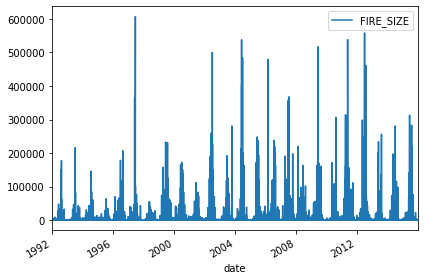

In [9]:
t1 = t.loc[:, ['date', 'FIRE_SIZE']]
t1.set_index('date', inplace = True)
t1.plot()
plt.tight_layout()

((array([-4.95129615, -4.77585527, -4.68112729, ...,  4.68112729,
          4.77585527,  4.95129615]),
  array([1.000000e-05, 9.000000e-05, 1.000000e-04, ..., 5.380490e+05,
         5.581983e+05, 6.069450e+05])),
 (240.92296801859325, 74.520158339924, 0.09646160835835862))

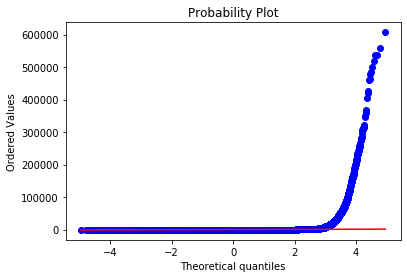

In [10]:
from scipy import stats
stats.probplot(t['FIRE_SIZE'], plot=plt)

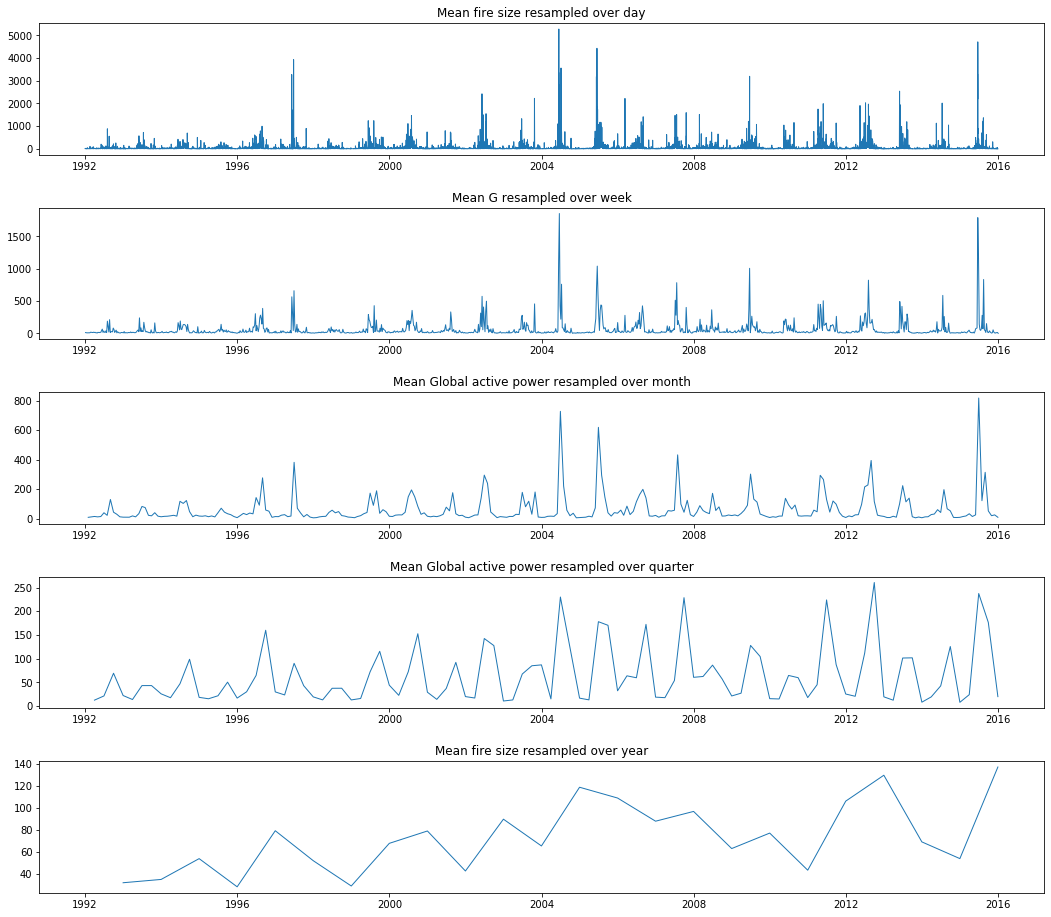

In [11]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(t1['FIRE_SIZE'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean fire size resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(t1['FIRE_SIZE'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean G resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(t1['FIRE_SIZE'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(t1['FIRE_SIZE'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(t1['FIRE_SIZE'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean fire size resampled over year')
ax5.tick_params(axis='both', which='major')

Text(0.5, 1.0, 'Mean fire size by Day')

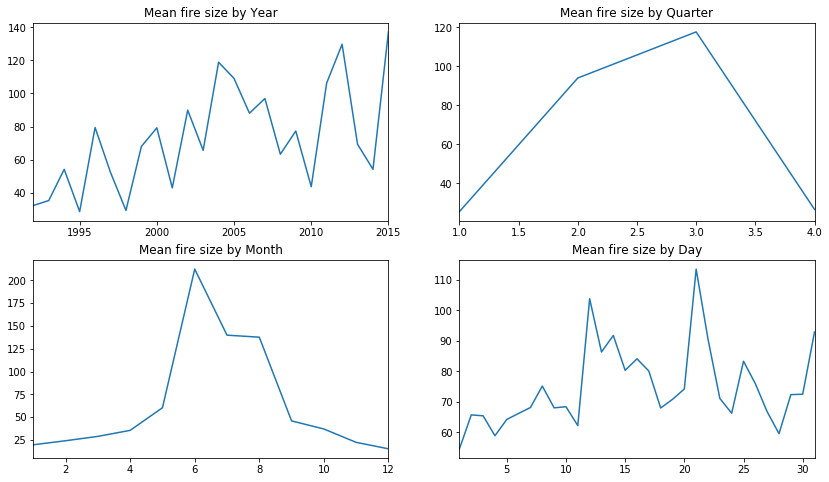

In [12]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
t.groupby('year').FIRE_SIZE.agg('mean').plot()
plt.xlabel('')
plt.title('Mean fire size by Year')

plt.subplot(2,2,2)
t.groupby('quarter').FIRE_SIZE.agg('mean').plot()
plt.xlabel('')
plt.title('Mean fire size by Quarter')

plt.subplot(2,2,3)
t.groupby('month').FIRE_SIZE.agg('mean').plot()
plt.xlabel('')
plt.title('Mean fire size by Month')

plt.subplot(2,2,4)
t.groupby('day').FIRE_SIZE.agg('mean').plot()
plt.xlabel('')
plt.title('Mean fire size by Day')

In [19]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [13]:
td=t1.resample('D', how=np.mean)
tm=t1.resample('M', how=np.mean)
tq=t1.resample('Q', how=np.mean)
ta=t1.resample('A', how=np.mean)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.
/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  
/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  after removing the cwd from sys.path.


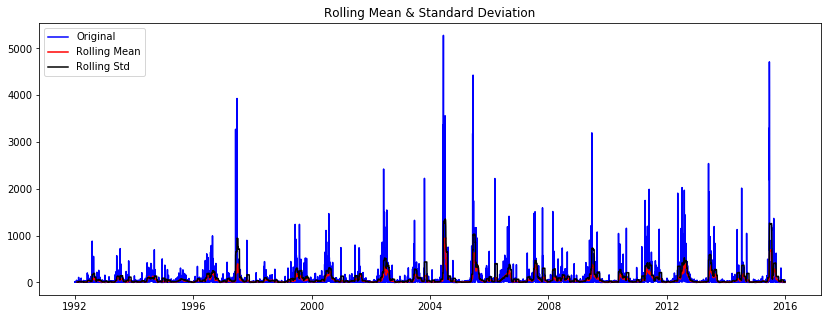

<Results of Dickey-Fuller Test>
Test Statistic                -1.101204e+01
p-value                        6.289876e-20
#Lags Used                     3.700000e+01
Number of Observations Used    8.728000e+03
Critical Value (1%)           -3.431099e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [21]:
test_stationarity(td.FIRE_SIZE)

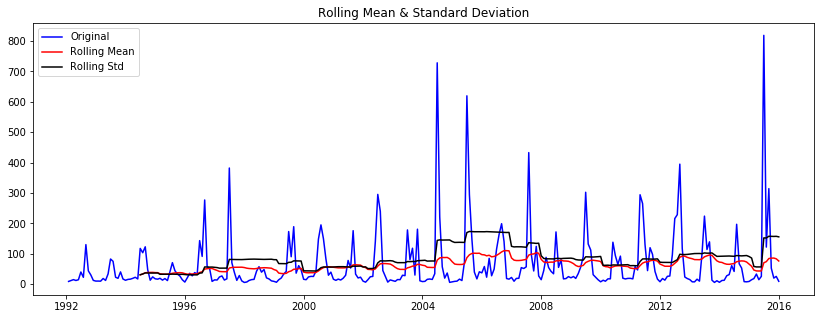

<Results of Dickey-Fuller Test>
Test Statistic                  -3.288447
p-value                          0.015403
#Lags Used                      11.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


In [22]:
test_stationarity(tm.FIRE_SIZE)

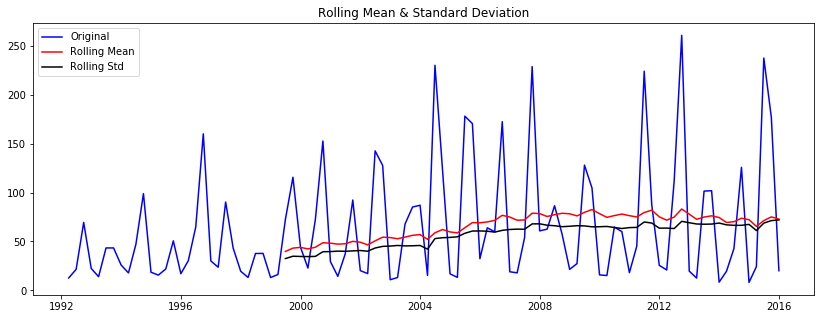

<Results of Dickey-Fuller Test>
Test Statistic                 -1.964709
p-value                         0.302258
#Lags Used                     10.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [23]:
test_stationarity(tq.FIRE_SIZE) #Non-stationary

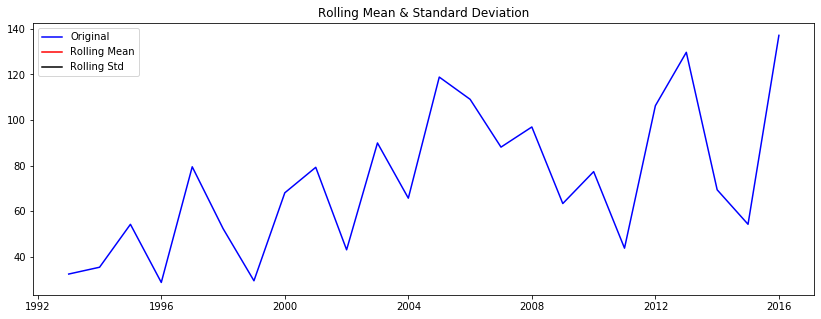

<Results of Dickey-Fuller Test>
Test Statistic                 -3.365535
p-value                         0.012191
#Lags Used                      0.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


In [24]:
test_stationarity(ta.FIRE_SIZE)

In [29]:
t1.FIRE_SIZE.values.shape

(1880465,)

In [27]:
dataset = t1.FIRE_SIZE.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1880465 entries, 2005-02-02 to 2015-03-14
Data columns (total 1 columns):
FIRE_SIZE    float64
dtypes: float64(1)
memory usage: 28.7 MB


In [30]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

NameError: name 'Sequential' is not defined

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [6]:
cc = pd.read_html('https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697')

In [19]:
fips_codes = cc[0].iloc[:-1, :]

In [ ]:
graph = probability_graph_fire_size(t)
draw_graph(graph)

In [ ]:
clean_col = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE']

In [ ]:
conn = create_connection('FPA_FOD_20170508.sqlite')
cur = conn.cursor()
cur.execute('SELECT OBJECTID, FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_DOY, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, OWNER_CODE, OWNER_DESCR, STATE FROM Fires WHERE FIRE_YEAR > 2014')
rows = cur.fetchall()

In [ ]:
clean_col = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE']

In [ ]:
t = pd.DataFrame(rows, columns = clean_col)


In [ ]:
type(t)

In [ ]:
t['STATE'].value_counts()

In [6]:
latest_5 = t[t['STATE'] != 'AK']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
X = latest_5[['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']]
y = latest_5['STAT_CAUSE_DESCR']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
clf = RandomForestClassifier(n_estimators = 100, max_depth=20, random_state =0, min_samples_split=2, verbose = 1)
clf.fit(X_train, y_train)#15 secish

In [ ]:
y_pred = clf.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

In [ ]:
clf.feature_importances_ #Longitude, Latitude, Day of Discovery, Fire size, fire year

In [7]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
crs = {'init':'epsg:4326'}

In [8]:
geometry = [Point(xy) for xy in zip(latest_5['LONGITUDE'], latest_5['LATITUDE'])]
geo_df = gpd.GeoDataFrame(latest_5, crs = crs, geometry = geometry)
geo_df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,FIRE_SIZE_CLASS,STATE,geometry
0,2014,195,0.1,45.340833,-116.466667,A,ID,POINT (-116.46667 45.34083)
1,2014,226,0.1,45.505278,-116.425556,A,ID,POINT (-116.42556 45.50528)
2,2014,235,0.1,45.908056,-115.767778,A,ID,POINT (-115.76778 45.90806)
3,2014,227,0.1,45.840000,-115.966389,A,ID,POINT (-115.96639 45.84000)
4,2014,204,0.1,45.598333,-115.449167,A,ID,POINT (-115.44917 45.59833)


In [ ]:
world = gpd.read_file(gpd.datasets.get_path('contiguous_usa'))
fig, ax = plt.subplots(figsize = (15,15))
na = world[world.continent == 'North America'].plot(ax = ax, color = 'white', edgecolor = 'black', alpha = 0.4)
geo_df[geo_df['FIRE_SIZE_CLASS'] == 'G'].plot(ax = ax, markersize = 10, color = 'red')
plt.show()


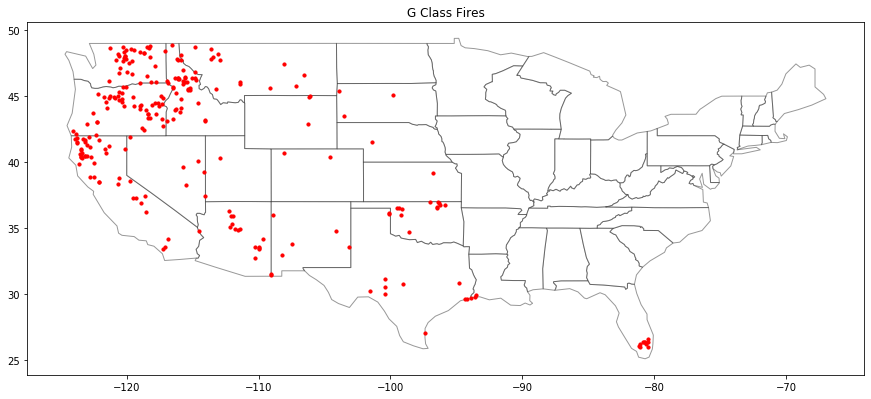

In [11]:
usa = gpd.read_file(geoplot.datasets.get_path('contiguous_usa'))
fig, ax = plt.subplots(figsize = (15,15))
na = usa.plot(ax = ax, color = 'white', edgecolor = 'black', alpha = 0.4)
geo_df[geo_df['FIRE_SIZE_CLASS'] == 'G'].plot(ax = ax, markersize = 10, color = 'red')
plt.title('G Class Fires')
plt.show()

In [ ]:
import geoplot
ax = geoplot.kdeplot(
    geo_df[geo_df['FIRE_SIZE_CLASS'] == 'G'], clip = usa.geometry,
    shade = True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
geoplot.polyplot(usa, ax=ax, zorder = 1)

In [ ]:
from datetime import datetime
now = datetime.now()
timestamp = datetime.timestamp(now)
timestamp

In [ ]:
get_it = get_weather(t, 980)

In [ ]:

get_copy = get_it.copy()

In [ ]:
get_it.loc[0,'RESPONSE']['hourly']['data']

In [ ]:
get_copy.iloc[:3]

get_copy['NEAREST-STATION'] = get_copy['RESPONSE']['flags']['nearest-station']
for hour in get_copy

In [ ]:
def clean_weather(df):
    for idx, row in df.iterrows():
        print(type(row))
#         row['NEAREST-STATION'] = row['RESPONSE']['flags']['nearest-station']
        for i, hour in enumerate(row['RESPONSE']['hourly']['data']):
            print(hour)
#             for key in hour:
#                 hour[str(i)+key] = hour.pop(key)
#             data = pd.DataFrame.from_dict(hour, orient='index')
#             print(data)
            
clean_weather(get_copy.iloc[:3])

In [ ]:
d.set_index('OBJECTID')


In [ ]:
sam = d.iloc[0:1,:]
sam['FIRE_YEAR'] = 1998
sam['OBJECTID'].isin(d['OBJECTID'])[0]